<a href="https://colab.research.google.com/github/michaelyliu6/Audio-Classification-using-TensorFlow/blob/main/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages


In [ ]:
!pip -q install librosa  
!pip3 -q install pydub

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa, librosa.display  
import matplotlib.pyplot as plt
import sklearn
import sys, os
from IPython.display import Audio
from IPython import display

# Obtaining Dataset

In [ ]:
ds, ds_info = tfds.load('speech_commands', split=['train', 'validation', 'test'],
                        as_supervised=True, with_info=True)  # download the data (takes about 20 mins)
train_set, valid_set, test_set = ds  # get train-validation-test split
ds_info  # display dataset info

Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteT6WPHB/speech_commands-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteT6WPHB/speech_commands-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/speech_commands/0.0.2.incompleteT6WPHB/speech_commands-test.tfrecord


Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='speech_commands',
    version=0.0.2,
    description='An audio dataset of spoken words designed to help train and evaluate keyword
spotting systems. Its primary goal is to provide a way to build and test small
models that detect when a single word is spoken, from a set of ten target words,
with as few false positives as possible from background noise or unrelated
speech. Note that in the train and validation set, the label "unknown" is much
more prevalent than the labels of the target words or background noise.
One difference from the release version is the handling of silent segments.
While in the test set the silence segments are regular 1 second files, in the
training they are provided as long segments under "background_noise" folder.
Here we split these background noise into 1 second clips, and also keep one of
the files for the validation set.',
    homepage='https://arxiv.org/abs/1804.03209',
    features=FeaturesDict({
        'audio': Audio(shap

In [ ]:
sample_rate = 16000
example = train_set.take(3) # example is a data set of COUNT elemtnts from train_set

for signal, label in tfds.as_numpy(example):
  print('Signal = ', signal, ', Label = ', label) # Array form
  display.display(Audio(signal, rate=sample_rate)) # Audio form

Signal =  [-15 -18 -12 ...  16  21  25] , Label =  4


Signal =  [  75   29  -85 ... -343  304  879] , Label =  5


Signal =  [0 0 2 ... 2 1 1] , Label =  7


# Visualization: Waveform


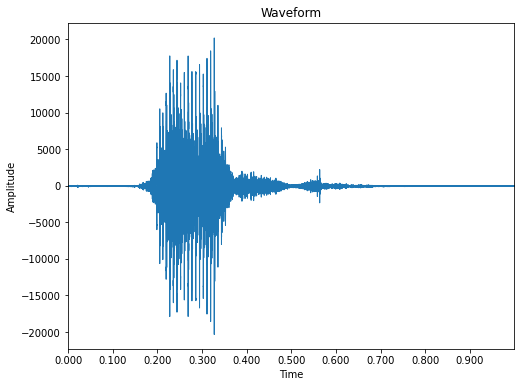

In [ ]:
# using the first entry from train_set
signal, label = list(tfds.as_numpy(train_set.take(1)))[0]
signal = signal.astype(np.float64)

# plot signal in a graph
plt.figure(figsize=(8,6))
librosa.display.waveplot(signal, sample_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

display.display(Audio(signal, rate=sample_rate))

# Visualization: Spectrogram
Obtained by applying STFT from the librosa package to the signal and taking the absolute value of the result.

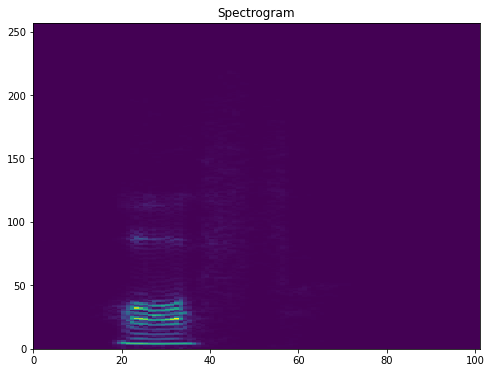

In [ ]:
spectrogram = np.abs(librosa.stft(signal, n_fft=512, hop_length=160))
plt.figure(figsize=(8,6))
plt.pcolormesh(spectrogram)
plt.title("Spectrogram")
plt.show()

# Visualization: Improved Spectrogram
Used librosa's amplitude to dB convertion function to make the spectrogram more intelligible.


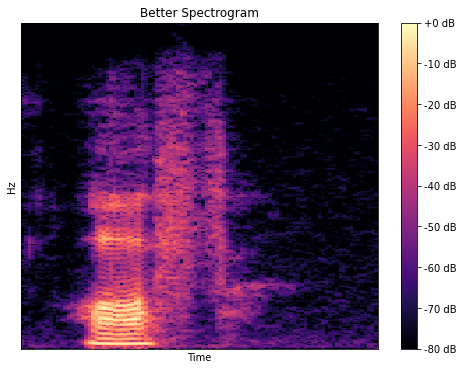

In [ ]:
plt.figure(figsize=(8,6))
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
librosa.display.specshow(spectrogram_db)
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time")
plt.ylabel("Hz")
plt.title("Better Spectrogram")
plt.show()


# Preprocessing: Filtering 
Filtered out the data to only include data with sample rate of 16,000 (removing about 8,000 samples)

In [ ]:
train_set = train_set.filter(lambda signal, label: len(signal) == sample_rate)
valid_set = valid_set.filter(lambda signal, label: len(signal) == sample_rate)
test_set = test_set.filter(lambda signal, label: len(signal) == sample_rate)

# Preprocessing: Transformation
The data is transformed into a magnitude spectrogram using the TensorFlow STFT function using 512 as the frame length and 160 as the frame step. Next, the magnitude spectrogram is converted into a decibel-scaled spectrogram.

In [ ]:
# Convert magnitude spectrogram to decible (dB) units
def power_to_db(signal, min=1e-16, top_db=80.0):
  # returns log base 10 of x 
  def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator
  
  
  ref = tf.reduce_max(signal) # returns max value in signal

  log_spectrogram = 10.0 * _tf_log10(tf.maximum(min, signal))
  log_spectrogram -= 10.0 * _tf_log10(tf.maximum(min, ref))
  log_spectrogram = tf.maximum(log_spectrogram, tf.reduce_max(log_spectrogram) - top_db)

  return log_spectrogram

def get_db_spec(signal):
  magnitude_spectrogram = tf.abs(tf.signal.stft(tf.cast(signal, tf.float32), 512, 160))
  return tf.transpose(power_to_db(tf.pow(magnitude_spectrogram, 2)))

# Transformation
train_set = train_set.map(lambda signal, label: (get_db_spec(signal), label))
test_set = test_set.map(lambda signal, label: (get_db_spec(signal), label))
valid_set = valid_set.map(lambda signal, label: (get_db_spec(signal), label))

# Preprocessing: Normalization
Normalize values by subtracting the mean of the tensor and dividing by the standard devation (plus a cushion to avoid dividing by zero).

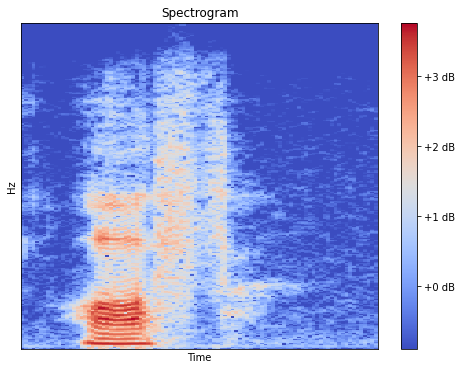

In [ ]:
def normalize(x, cushion=1e-10):
  return (x - tf.math.reduce_mean(x)) / (tf.math.reduce_std(x) + cushion)

# Normalization
train_set = train_set.map(lambda signal, label: (normalize(signal), label))
test_set = test_set.map(lambda signal, label: (normalize(signal), label))
valid_set = valid_set.map(lambda signal, label: (normalize(signal), label))

# Plot
plt.figure(figsize=(8,6))
librosa.display.specshow(list(tfds.as_numpy(train_set.take(1)))[0][0])
plt.colorbar(format="%+2.0f dB")
plt.xlabel('Time')
plt.ylabel('Hz')
plt.title("Spectrogram")
plt.show()

# Architecture
First, the input is reshaped to 257x97x1. Next, are a series of 3 convolutional layers which are followed by batch normalization layers, which are followed by ReLu activations, which are followed by pooling. Padding is always used so that all pixels are considered during convolutional and pooling processes.
Finally, the output is a dense layer with softmax activation.
<center>
<img src="https://drive.google.com/thumbnail?id=1bAtVD-ffxyVi91kzfghXk3P0_rTDlCxf&sz=w3800" alt="cnn_diagram"/>
<i>Diagram of a deep convolutional neural network that is implemented.</i>
</center>


In [ ]:
from tensorflow.keras import layers, models

input_shape = (257, 97)

def cnn():
  i = layers.Input(shape=input_shape,name='input')
  reshaped = layers.Reshape((input_shape[0], input_shape[1], 1))(i)
  h = layers.Conv2D(12,kernel_size=(3,3), padding='same', name='conv2d_relu_1')(reshaped)
  h = layers.BatchNormalization()(h)
  h = layers.Activation('relu')(h)
  h = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name='max_pool_2d_1')(h)
  h = layers.Conv2D(24, kernel_size=(3,3), padding='same', name='conv2d_relu_2')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Activation('relu')(h)
  h = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name='max_pool_2d_2')(h)
  h = layers.Conv2D(48, kernel_size=(3,3), padding='same', name='conv2d_relu_3')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Activation('relu')(h)
  h = layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name='max_pool_2d_3')(h)

  h = layers.Conv2D(48, kernel_size=(3,3), padding='same', name='conv2d_relu_4')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Activation('relu')(h)
  h = layers.Conv2D(48, kernel_size=(3,3), padding='same', name='conv2d_relu_5')(h)
  h = layers.BatchNormalization()(h)
  h = layers.Activation('relu')(h)

  h = layers.GlobalMaxPool2D()(h)

  h = layers.Dropout(rate=0.2, name='dropout')(h)
  h = layers.Dense(12, name='dense')(h)
  o = layers.Dense(12, activation='softmax', name='cnn')(h)

  model = models.Model(inputs=i, outputs=o, name='cnn')
  model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = cnn()
model.summary()   





Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 257, 97)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 257, 97, 1)        0         
_________________________________________________________________
conv2d_relu_1 (Conv2D)       (None, 257, 97, 12)       120       
_________________________________________________________________
batch_normalization (BatchNo (None, 257, 97, 12)       48        
_________________________________________________________________
activation (Activation)      (None, 257, 97, 12)       0         
_________________________________________________________________
max_pool_2d_1 (MaxPooling2D) (None, 129, 49, 12)       0         
_________________________________________________________________
conv2d_relu_2 (Conv2D)       (None, 129, 49, 24)       2616    

# Training 

Epoch 1/25
602/602 [==============================] - 412s 674ms/step - loss: 0.3672 - accuracy: 0.8813 - val_loss: 0.2336 - val_accuracy: 0.9241
Epoch 2/25
602/602 [==============================] - 443s 723ms/step - loss: 0.2917 - accuracy: 0.9066 - val_loss: 0.2046 - val_accuracy: 0.9399
Epoch 3/25
602/602 [==============================] - 378s 621ms/step - loss: 0.2494 - accuracy: 0.9211 - val_loss: 0.2084 - val_accuracy: 0.9421
Epoch 4/25
602/602 [==============================] - 408s 670ms/step - loss: 0.2144 - accuracy: 0.9310 - val_loss: 0.2252 - val_accuracy: 0.9239
Epoch 5/25
602/602 [==============================] - 407s 670ms/step - loss: 0.1950 - accuracy: 0.9390 - val_loss: 0.1644 - val_accuracy: 0.9489
Epoch 6/25
602/602 [==============================] - 403s 663ms/step - loss: 0.1751 - accuracy: 0.9445 - val_loss: 0.1363 - val_accuracy: 0.9590
Epoch 7/25
602/602 [==============================] - 405s 667ms/step - loss: 0.1666 - accuracy: 0.9469 - val_loss: 0.1627 -

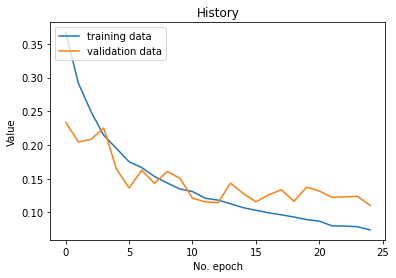

In [ ]:
from keras.callbacks import ModelCheckpoint

batched_train_set = train_set.shuffle(buffer_size=1024).batch(128)
batched_valid_set = valid_set.shuffle(buffer_size=1024).batch(128)

history = model.fit(batched_train_set,
                    epochs=25,
                    validation_data=batched_valid_set,
                    callbacks=[ModelCheckpoint('mdl_wts.hdf5',
                                               save_best_only=True,
                                               monitior='val_loss',
                                               mode='min')],
                    workers=2,
                    use_multiprocessing=True)

# plot performance 
plt.plot(history.history['loss'], label='training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('History')
plt.xlabel('No. epoch')
plt.ylabel('Value')
plt.legend(loc="upper left")
plt.show()

# Testing
Testing how well our trained model preforms on the test set and using Keras' evulate function to get test loss, test accuracy, and plot a confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd 
import seaborn as sns

class_names = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up',
               'yes','unknown', 'silence']

# evaluation
batched_test_set = test_set.shuffle(buffer_size=1024).batch(128)
print(model.evaluate(batched_test_set))

# confusion matrix
true = []
pred = []
for signals, labels in batched_test_set.as_numpy_iterator():
  print('.', end='')
  for signal in signals:
    pred.append(np.argmax(model.predict(np.array([signal]))))    
  for label in labels:
    true.append(label)


39/39 [==============================] - 16s 334ms/step - loss: 0.3015 - accuracy: 0.9247
[0.3015176057815552, 0.9247443675994873]
.......................................

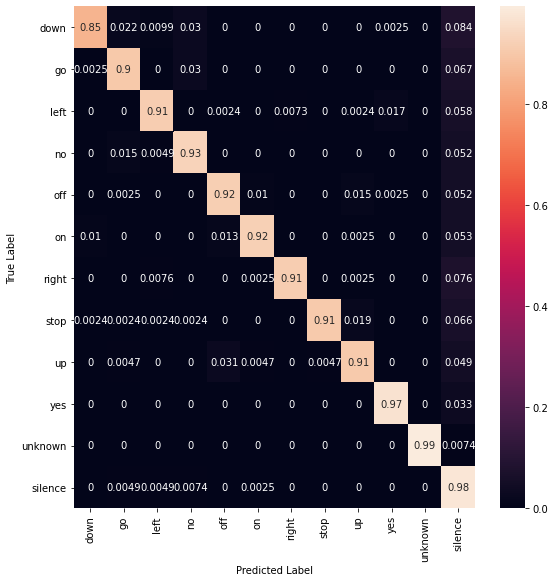

In [ ]:
# plot
conf_mat = confusion_matrix(true, pred, normalize='true')
data_frame = pd.DataFrame(conf_mat, 
                          index = class_names,
                          columns = class_names)

plt.figure(figsize=(8,8))
sns.heatmap(data_frame, annot=True)
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# At Home Test
Using a Web Audio API, we can test how well our model can predict when listening to our own voice when saying one of the target words. 

In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1.1):
  print('Recording...')
  display.display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  fp = 'my_rec.wav'
  with open(fp,'wb') as f:
    f.write(b)
  print('Done.')
  return fp


# Recording
fp = record()
signal, sr = librosa.load(fp, sr=16000)
signal = signal[-sr:]
display.display(Audio(signal, rate=sr))

# Prediction
spec = normalize(get_db_spec(signal))
one_hot_pred = model.predict(np.array([spec]))
pred_to_text = class_names[np.argmax(one_hot_pred)]
print('You said', pred_to_text)

Recording...


<IPython.core.display.Javascript object>

Done.


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


You said right
